[From official `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)<br>
Adapted by Claudio Sartori

# Classification with Decision Tree - hyperparameter tuning (__model selection__) with Grid Search and Cross Validation

We use here the Decision Tree and the standard `CrossValidation`, then find the best hyperparameter setting through _grid search_


### Workflow
1. download the data
1. data exploration
1. drop the useless data (if any)
1. separe the predicting attributes X from the class attribute y
1. split X and y into training and test
    - set a variable `target` with the column name of the target
1. single run with default parameters
    - initialise a estimator with the DecisionTreeClassifier
    - fit the estimator with the training part of X
    - show the tree structure
        - in particular, observe the maximum depth of the tree, this will be used in choosing the range for the `max_depth` hyperparameter
    - predict the y values with the fitted estimator and the train data
        - compare the predicted values with the true ones and compute the accuracy on the training set 
    - predict the y values with the fitted estimator and the test data
        - compare the predicted values with the true ones and compute the accuracy on the test set
        - this will be our baseline

## Model selection

- the *train* part will be used for training and _cross-validation_ (i.e. for *development*)
- the *test* part will be used for test (i.e. for *evaluation*)
- the fraction of train data will be __train_size__ (a value of your choice between 0.67 and 0.8)
- the function `GridSearchCV` iterates a cross validation experiment to __train__ and __validate__ a model with different combinations of paramater values
- for each parameter we set a list of values to test, the `GridSearchCV` function will generate all the combinations
- we will make several experiments with the optimisation of different *score function* 
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for reference
    - the output is a dictionary containing 
        - the set of parameters which maximize the score 
        - the test scores


In [2]:
"""
http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
@author: scikit-learn.org and Claudio Sartori
"""
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

### Prepare the environment

- Import all the relavant libraries
- set the `random_state`
- set the fraction to use for training `train_size`
- set the number of cross-validation splits `n_splits`
- set the url for the data `data_url`
- set the name of the `target`

In [3]:
# hint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size'   : 12})
random_state = 17
train_size = 0.67
n_splits = 3
np.random.seed(random_state)
# the random state is reset here in numpy, all the scikit-learn procedure use the numpy random state
# obviously the experiment can be repeated exactly only with a complete run of the program

# data_url = "../data/winequality-red.csv"
data_url = "default-of-credit-card-clients.xlsx"
# sep = ';'
# sep = ','
target = 'DPNM'

Read the data into a dataframe and show the size

In [4]:
df = pd.read_excel(f"../data/{data_url}", header=1)
display(f"The Shape of the input data {df.shape}")

'The Shape of the input data (30000, 25)'

Show the head of the dataframe and try to understand if everything is fine.

If necessary, adjust the read of previous cell adding parameters. (Hint: consider using `skiprows`)

In [5]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DPNM
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Examine the short description provided by `.describe(include='all)`

`counts` counts the valid vaules, if it is equal to the number of rows it means that there are no missing values in the colmumn

The other rows are simple descriptive statistics

In [6]:
df.describe(include='all')

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DPNM
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Additional insights are provided by the number of distinct values in each column, or the average number of rows per distinct values of a column

This latter ratio can be obtained dividing the number of rows by the result of the `nunique()` method. The result is a series that can be sorted with the `().sort_values()` method.

Meaning of this ratio:
- Usually, it is exactly `1` when a column is an __identifier__. Usually identifiers are not useful for machine learning and must be dropped
- Usually it is a non integer small number (e.g. a few units) for continuous attributes.
- Usually it is a larger number (of the order of magnitude of the nunber of rows) for discrete attributes


In [7]:
(len(df) / df.nunique()).sort_values()

ID               1.000000
BILL_AMT1        1.320248
BILL_AMT2        1.342522
BILL_AMT3        1.362027
BILL_AMT4        1.392241
BILL_AMT5        1.427891
BILL_AMT6        1.456028
PAY_AMT1         3.776910
PAY_AMT2         3.797949
PAY_AMT3         3.990423
PAY_AMT6         4.323390
PAY_AMT4         4.324636
PAY_AMT5         4.349717
LIMIT_BAL      370.370370
AGE            535.714286
PAY_4         2727.272727
PAY_3         2727.272727
PAY_2         2727.272727
PAY_0         2727.272727
PAY_6         3000.000000
PAY_5         3000.000000
EDUCATION     4285.714286
MARRIAGE      7500.000000
SEX          15000.000000
DPNM         15000.000000
dtype: float64

In [8]:
df = df.drop(columns=['ID'])

Show a pie chart of the __target__ labels frequencies (hint: use the `value_counts` method)

([<matplotlib.patches.Wedge at 0x15ff42210>,
 [Text(-0.8449152390547129, 0.704356613380692, '0'),
  Text(0.844915272028025, -0.7043565738273541, '1')],
 [Text(-0.460862857666207, 0.38419451638946833, '77.9%'),
  Text(0.4608628756516499, -0.38419449481492035, '22.1%')])

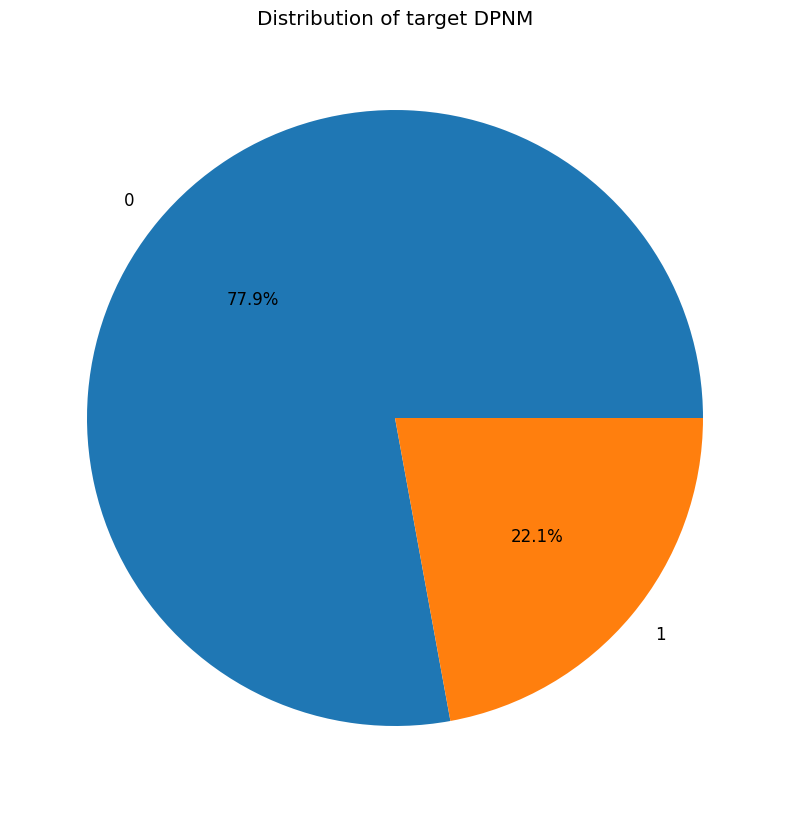

In [9]:
plt.title('Distribution of target DPNM')
plt.pie(data=df, x=df[target].value_counts(), labels=df[target].value_counts().index, autopct='%1.1f%%')

#### Split the data into the __predicting values__ `X` and the __target__ `y`
Drop also the columns which are not relevant for training a classifier, if any

The method "drop" of dataframes allows to drop either rows or columns
- the "axis" parameter chooses between dropping rows (axis=0) or columns (axis=1)

In [10]:
X = pd.DataFrame(df.drop(target, axis=1))
X

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,3502,8979,5190,0,1837,3526,8998,129,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,2758,20878,20582,19357,0,0,22000,4200,2000,3100
29998,80000,1,3,1,41,1,-1,0,0,0,...,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804


### Prepare the baseline: holdout method

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.33, random_state=random_state)

print(f"There are {len(X_train)} samples in the training dataset" + "\n" + f"There are {len(X_test)} samples in the test datase" + "\n" + f"Each sample has {len(X_train.columns)} features")

There are 20100 samples in the training dataset
There are 9900 samples in the test datase
Each sample has 23 features


- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(random_state = random_state)`


In [12]:
tree_model = DecisionTreeClassifier(random_state=random_state)

- Fit the estimator on the train data and target

In [13]:
tree_model.fit(X_train, y_train)
display(f"Accuracy on the training set {tree_model.score(X_train, y_train):.2%}")

'Accuracy on the training set 99.97%'

Let's see how it works on test data, and, comparing with the result on training data, see if you can suspect *overfitting*
- use the fitted estimator to predict using the test features
- compute the accuracy and store it on a variable for the final summary
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

In [14]:
test_data_prediction = tree_model.predict(X_test)
fitted_max_depth = tree_model.tree_.max_depth
display(f"The accuracy of test set is {accuracy_score(y_test, test_data_prediction):.2%}%")
display(f"The maximum depth of the tree fitted on X_train is {fitted_max_depth}")

'The accuracy of test set is 72.31%%'

'The maximum depth of the tree fitted on X_train is 56'

There is clearly overfitting, since the training accuracy is 100% and the testing accuracy is 72.3%

We need to optimize the __hyperparameters__ of the decision tree.<br>
We will also execute several optimization loops in order to maximize different performance measures

Prepare the grid of hyperparameter values to search for the best performance 

In [15]:
# hint
# Set the parameters to search in the different cross-validation rounds
tuned_param_dt = [{'max_depth': [*range(1,7)] 
                        # [*range(1,fitted_max_depth+1)]
                        # in principle we should use this, but for "default-of-credit-card-clients.xlsx"
                        # 7 is enough and with 56 the running time is a bit long
                , 'criterion' : ['entropy', 'gini']
                , 'class_weight' : [None, 'balanced']}]

scores = ['accuracy'
        , 'precision_macro'
        , 'recall_macro'
        , 'f1_macro']

## Value of the decisions assisted by the classifier

Let's assume that we have an evaluation of the average gain due to a correct prediction of default and non-default, and of the average cost due to a wrong prediction, either of undetected default or default prediction for a client that is not going to default.

We also assume a given number of customers per month and evaluate quantitatively the advantage given by the data driven prediction of default

In [16]:
# hint
# I am not an expert of the field, therefore those values are just examples
value_DPNM_00 =   0 # correct prediction on non-default
value_DPNM_11 =  10 # correct prediction on default
value_DPNM_10 = -10 # wrong prediction on default
value_DPNM_01 =  -2 # wrong prediction on non-default

customer_x_month = 10000

Genarate and show the `cost_matrix`

In [17]:
cost_matrix = np.array([[value_DPNM_00, value_DPNM_01]
                        ,[value_DPNM_10, value_DPNM_11]])
cost_matrix

array([[  0,  -2],
       [-10,  10]])

### Loop on scores
- prepare the split method and initialize its random state
- iterate varying the score function
    - fit the estimator using the training data
        - the resulting model will be the best one according to the current score function
    - print the best estimator
    - print the best score
    - predict the target for the test set using the `.predict` method
    - print the `classification_report` passing the test ground truth and the test prediction
    - generate and store the `confusion_matrix` passing the test ground truth and the test prediction
        - the parameter `normalize='true'` forces the production of percentages, instead of counts, normalized with respect to the ground truth
        - alternatives are `normalize='pred'` for normalization to predictions `normalize='all'` for normalization to all the samples
    - print the __monthly value__ given by the best estimator for the current score
    - display the confusion matrix with `ConfusionMatrixDisplay`
        

In [18]:
# hint
skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)

Hints: 
- start developing the process for a single scoring, e.g. `accuracy`, then you can enclose it in the loop for the various scores
- The best idea is to execute step by step each requirement. Use `GridSearchCV` for the hyperparameter tuning and be sure to check the documentation to undertand all the parameter you need to set `(estimator, param_grid, scoring, cv)` 

In [30]:
confusion_matrixes_details = []

In [31]:
for score in scores:
    gsm = GridSearchCV(
        estimator=tree_model, cv=skf, param_grid=tuned_param_dt, scoring=score
    )

    gsm.fit(X_train, y_train)

    print(gsm.best_params_)
    print(gsm.best_score_)

    single_prediction_result = gsm.predict(X_test)

    print(f"Best score {gsm.best_score_*100:.3f}% for {score}")
    report = classification_report(y_test, single_prediction_result)
    print(report)
    conf_matrix = confusion_matrix(y_test, single_prediction_result, normalize="true")
    confusion_matrixes_details.append(
        {
            "matrix": conf_matrix,
            "score": score,
            "criterion": gsm.best_params_["criterion"],
            "max_depth": gsm.best_params_["max_depth"],
            "class_weight": gsm.best_params_["class_weight"],
        }
    )

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 1}
0.8186567164179105
Best score 81.866% for accuracy
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      7719
           1       0.69      0.34      0.46      2181

    accuracy                           0.82      9900
   macro avg       0.77      0.65      0.67      9900
weighted avg       0.81      0.82      0.80      9900

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 2}
0.7668776045808517
Best score 76.688% for precision_macro
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      7719
           1       0.70      0.33      0.45      2181

    accuracy                           0.82      9900
   macro avg       0.77      0.65      0.67      9900
weighted avg       0.81      0.82      0.80      9900

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5}
0.6955144284003344
Best score 69.551% for 

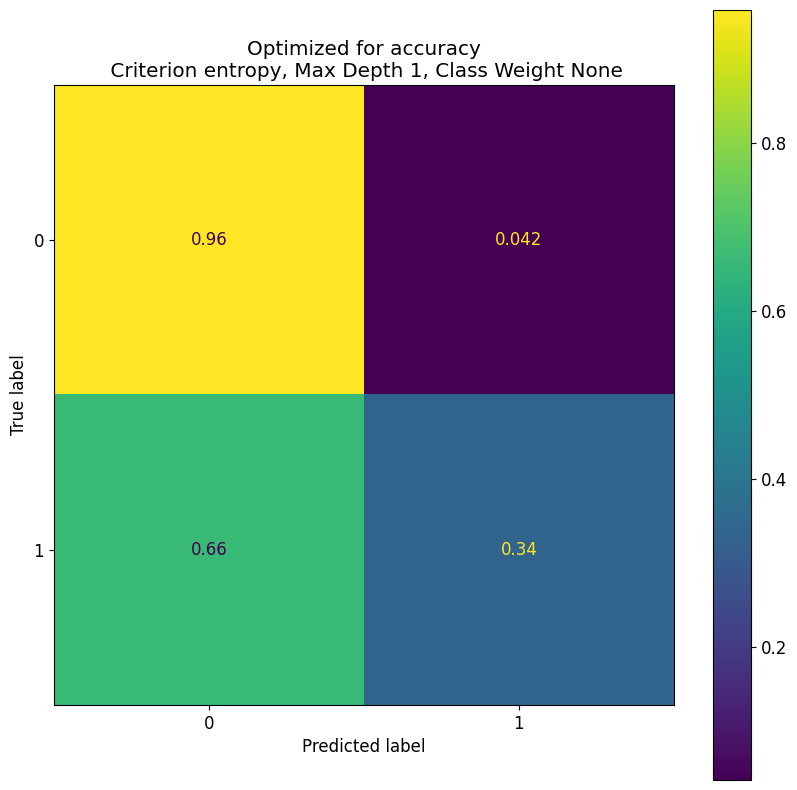

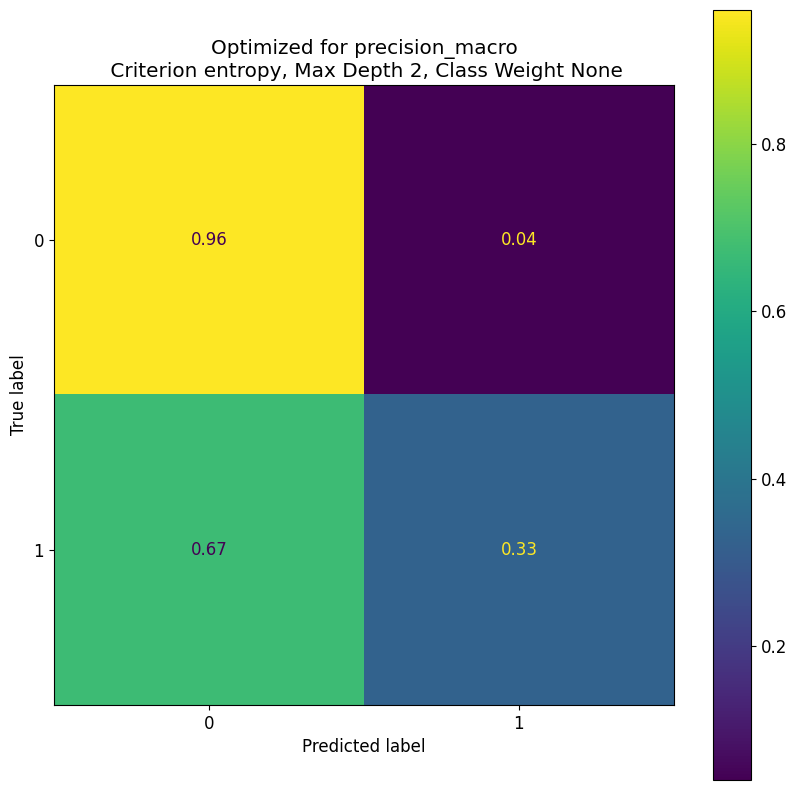

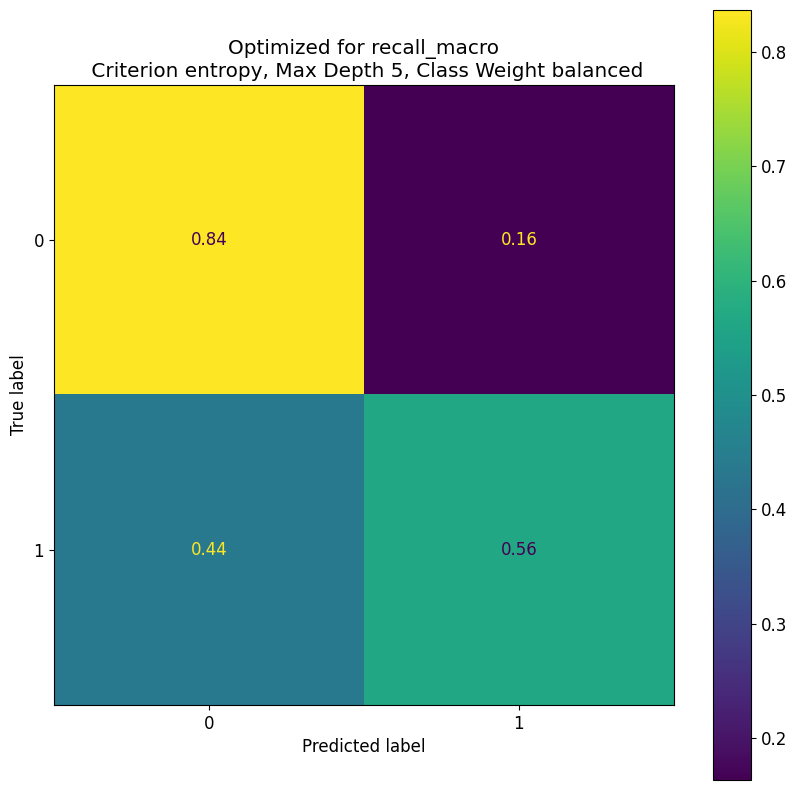

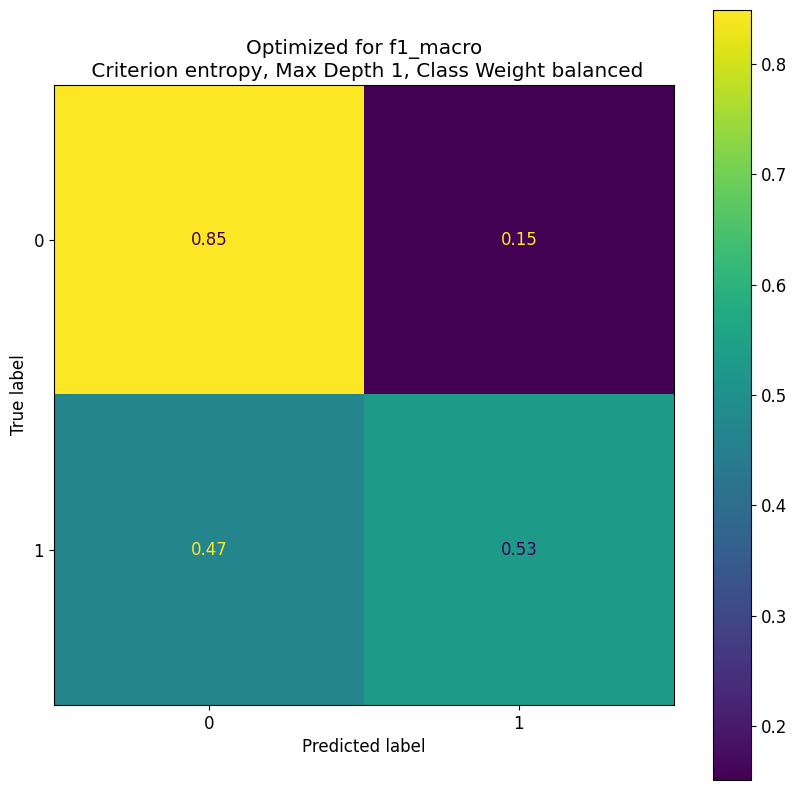

In [32]:
for matrix_details in confusion_matrixes_details:
    ConfusionMatrixDisplay(matrix_details["matrix"], display_labels=["0", "1"]).plot()
    plt.title(
        f"Optimized for {matrix_details['score']}\n Criterion {matrix_details['criterion']}, Max Depth {matrix_details['max_depth']}, Class Weight {matrix_details['class_weight']}"
    )
    plt.show()